In [50]:
import matplotlib.pyplot as plt
import numpy as np
import abtem
from ase import Atoms
import ase
from abtem.core.energy import energy2wavelength
from scipy.interpolate import RegularGridInterpolator
import cupy as cp  # noqa
%matplotlib ipympl

xp = cp

if xp == cp:
    from cupyx.scipy.interpolate import RegularGridInterpolator
else:
    from scipy.interpolate import RegularGridInterpolator


In [51]:
def get_phase_from_opl(opl, wavelength):
    return xp.mod((opl/wavelength) * (2*xp.pi), 2*xp.pi)

def convert_slope_to_unit_vector(dx, dy):
    
    rho = xp.sqrt(1 + dx ** 2 + dy ** 2)
    unit_vector_x = dx / rho
    unit_vector_y = dy / rho
    unit_vector_z = 1 / rho

    return xp.array([unit_vector_x, unit_vector_y, unit_vector_z])

def get_pixel_coords(
    rays_x, rays_y, shape, pixel_size
):

    transform = xp.eye(2)

    y_transformed, x_transformed = (xp.array((rays_y, rays_x)).T @ transform).T

    sy, sx = shape
    pixel_coords_x = (x_transformed / pixel_size) + (sx // 2)
    pixel_coords_y = (y_transformed / pixel_size) + (sy // 2)

    return (pixel_coords_x, pixel_coords_y)


In [52]:
# Define the number of slices and slice thickness
slice_thickness = 0.2  # in Angstroms

# Calculate the total thickness of the cell
total_thickness = 1

num_slices = int(total_thickness / slice_thickness)

cell_x = 12
cell_y = 12
cell_z = total_thickness

# # # Create a cell with a large z-dimension
cell = [cell_x, cell_y, cell_z]  # 10x10 Angstroms in x and y, total_thickness in z

half_x = cell[0] / 2
half_y = cell[1] / 2
half_z = cell[2] / 2

# # # Place a single gold atom at the center of the cell
# position = [cell_x / 2, cell_y / 2, total_thickness / 2]
# atoms = Atoms('Au', positions=[position], cell=cell, pbc=[False, False, False])

# # # Place a single gold atom at the center of the cell
# position0 = [cell_x / 2, cell_y / 3, total_thickness / 2]
# # position1 = [cell_x / 2, cell_y * 2 / 3, total_thickness / 2]
# atoms = Atoms('Au', positions=[position0], cell=cell, pbc=[False, False, False])

unit_cell = ase.build.bulk("Au", cubic=True)
atoms = unit_cell * (cell_x, cell_y, cell_z)

# Get the size of the unit cell in Angstroms
unit_cell_size = unit_cell.cell.lengths()

# Calculate the size of the supercell
supercell_size_x = unit_cell_size[0] * cell_x
supercell_size_y = unit_cell_size[1] * cell_y
supercell_size_z = unit_cell_size[2] * cell_z

# Calculate the extent of the cell
half_x = supercell_size_x / 2
half_y = supercell_size_y / 2
half_z = supercell_size_z / 2

extent_x = (-half_x / 2, half_x / 2)
extent_y = (-half_y / 2, half_y / 2)
extent_z = (-half_z / 2, half_z / 2)

potential = abtem.Potential(
    atoms,
    slice_thickness=slice_thickness,
    sampling=0.02,
    projection="finite",
)

PHI_0 = 80e3
wavelength = energy2wavelength(PHI_0)

# Compute the potential
V = potential.build().compute().array

# Define the offset (atom position)
offset = [0, 0, 0]  # Place the atom at the origin

print(half_x, half_y)


[########################################] | 100% Completed | 64.92 s
24.48 24.48


Text(0.5, 1.0, 'Potential')

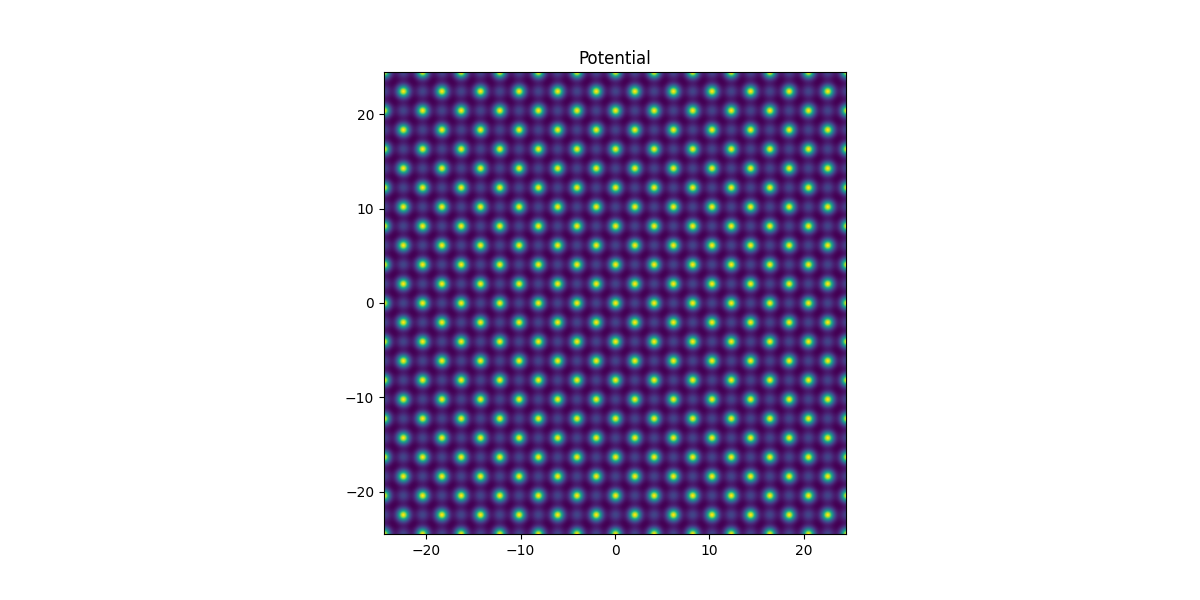

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(V[4, :, :], extent = (-half_x, half_x, -half_y, half_y))
ax.set_title('Potential')


In [54]:
if xp == cp:
    V = cp.array(V)
    

k = 2 * xp.pi / wavelength

V_xyz = PHI_0 - V.T

n = xp.sqrt(V_xyz / PHI_0)
dndx, dndy, dndz = xp.gradient(n)

print(n.shape)
nx, ny, nz = V.T.shape

x = xp.linspace(-half_x, half_x, nx, endpoint = False)  # x coordinates
y = xp.linspace(-half_y, half_y, ny, endpoint = False)  # y coordinates
z = xp.linspace(-half_z, half_z, nz, endpoint = True)  # z coordinates

n_interp = RegularGridInterpolator((x, y, z), n, method = 'linear', bounds_error=False, fill_value=1.0)
dndx_interp = RegularGridInterpolator((x, y, z), dndx, method = 'linear', bounds_error=False, fill_value=0.0)
dndy_interp = RegularGridInterpolator((x, y, z), dndy, method = 'linear', bounds_error=False, fill_value=0.0)
dndz_interp = RegularGridInterpolator((x, y, z), dndz, method = 'linear', bounds_error=False, fill_value=0.0)

xx, yy = xp.meshgrid(x, y)

(2448, 2448, 21)


In [55]:
def step_slice(r, z, dz, n, dndx, dndy, dndz):

    #Use the Euler-Cromer method to step the electron through the refractive index potential
    
    #Get coordinates
    x, dx, y, dy, opl = r.T
    
    #Get tangent vector from slope
    rho = xp.sqrt(1 + dx **2 + dy ** 2)
    
    #Add phase shift
    opl = opl + n((x, y, z)) * rho * dz
    
    #Update slopes
    dx = dx + rho ** 2 / n((x, y, z)) * (dndx((x, y, z)) - dx * dndz((x, y, z))) * dz
    dy = dy + rho ** 2 / n((x, y, z)) * (dndy((x, y, z)) - dy * dndz((x, y, z))) * dz
    
    #Return updated coordinates to vector
    r = xp.vstack((x, dx, y, dy, opl)).T
    
    return r

def step_z(r, z, dz):
    x, dx, y, dy, opl = r.T
    
    rho = xp.sqrt(1 + dx **2 + dy ** 2)
    opl = opl + 1.0 * rho * dz
    
    #Update positions
    x = x + dx * dz
    y = y + dy * dz
    z = z + dz
    
    r = xp.vstack((x, dx, y, dy, opl)).T
    
    return r, z

In [56]:
num_rays = int(1e6)
print(num_rays)
z0_atom = -half_z
dz = slice_thickness

# Generate random angles and radii
angles = xp.random.uniform(0, 2 * xp.pi, num_rays)
radii = xp.random.uniform(0, 10, num_rays)

# Convert polar coordinates to Cartesian coordinates
# x0s = xp.random.uniform(-0.5, 0.5, num_rays)
# y0s = xp.concatenate([xp.random.uniform(-2.5, -1.5, num_rays//2), xp.random.uniform(1.5, 2.5, num_rays//2)])
# y0s = xp.concatenate([xp.random.uniform(-2.5, -1.5, num_rays)])

x0s = radii * xp.cos(angles)
y0s = radii * xp.sin(angles)

z0 = -1000

dx0 = 0.0
dy0 = 0.0
opl0 = 0.0

rho = xp.sqrt(dx0 ** 2 + dy0 ** 2)
dz0 = z0_atom - z0
z1 = z0 + dz0

r = xp.zeros((num_rays, num_slices + 3, 5))

z_sol = xp.zeros(num_slices + 3)
z_sol[0] = z0

r[:, 0, 0] = x0s
r[:, 0, 1] = dx0
r[:, 0, 2] = y0s
r[:, 0, 3] = dy0
r[:, 0, 4] = opl0


1000000


In [57]:

r[:, 1, :], z_sol[1] = step_z(r[:, 0, :], z_sol[0], dz0)
i_start = 1

for i in range(num_slices):
    r[:, i + i_start, :] = step_slice(r[:, i + i_start, :], z_sol[i + i_start], dz, n_interp, dndx_interp, dndy_interp, dndz_interp)
    r[:, i + i_start + 1, :], z_sol[i + i_start + 1] = step_z(r[:, i + i_start, :], z_sol[i + i_start], dz)

dzend = 1000000
r[:, -1, :], z_sol[-1] = step_z(r[:, -2, :], z_sol[-2], dzend)

x_sol = r[:, :, 0]
dx_sol = r[:, :, 1]
y_sol = r[:, :, 2]
dy_sol = r[:, :, 3]
opl = r[:, :, -1]

print(np.max(x_sol), np.max(y_sol))

929.4298642676157 934.826091894792


In [58]:
# fig, ax = plt.subplots()
# ax.plot(z_sol, y_sol.T, '-')
# ax.set_xlabel("z (angstroms)")
# ax.set_ylabel("x (angstroms)")
# ax.set_title("Particle Trajectory around atomic potential")

In [59]:
n_pixels_x = 200
n_pixels_y = 200
detector_width_x = 20
detector_width_y = 20

# Create 2D grid for detector pixels
detector_pixels_x, px_size_x = xp.linspace(-detector_width_x/2, detector_width_x/2, n_pixels_x, retstep=True)
detector_pixels_y, px_size_y = xp.linspace(-detector_width_y/2, detector_width_y/2, n_pixels_y, retstep=True)
detector_pixels_z = xp.ones((n_pixels_x, n_pixels_y)) * z_sol[-1]

# Create a meshgrid for detector points
detector_pixels_x, detector_pixels_y = xp.meshgrid(detector_pixels_x, detector_pixels_y)
det_shape = (n_pixels_x, n_pixels_y)

det_points = xp.vstack([
    detector_pixels_x.ravel(), 
    detector_pixels_y.ravel(),  
    detector_pixels_z.ravel()
]).T

print(det_points.shape)

(40000, 3)


In [60]:
det_image = xp.zeros((n_pixels_x, n_pixels_y), xp.complex128)

x, dx, y, dy, opl = r[:, -1, :].T

ray_unit_direction_vector = convert_slope_to_unit_vector(dx, dy).T #z, x
ray_points = xp.vstack([x, y, xp.ones(num_rays) * z_sol[-1]]).T #z, x
ray_phase = get_phase_from_opl(opl, 2)

# for i in range(num_rays):
#     v = ray_points[i, :] - det_points
#     dist = xp.dot(v, ray_unit_direction_vector[i, :].T)
#     phase_shift_to_detector = get_phase_from_opl(dist, wavelength)
    
#     phase_shift_to_detector = phase_shift_to_detector.reshape(n_pixels_x, n_pixels_y)
#     det_image += 1.0 * xp.exp(1j * (ray_phase[i] + phase_shift_to_detector))

In [61]:
# Plotting the detector pixels
# plt.figure(figsize=(10, 8))
# plt.imshow(xp.abs(det_image), extent=[-detector_width_x/2, detector_width_x/2, -detector_width_y/2, detector_width_y/2], cmap='viridis')
# plt.colorbar(label='Amplitude')
# plt.xlabel('X (Å)')
# plt.ylabel('Y (Å)')
# plt.title('Detector Image')
# plt.show()

In [62]:
chunk_size = 1000

# Process in chunks
for start in range(0, num_rays, chunk_size):
    end = min(start + chunk_size, num_rays)
    
    # Calculate the difference vectors for the current chunk
    v_chunk = ray_points[start:end, xp.newaxis, :] - det_points  # Shape: (chunk_size, n_pixels_x * n_pixels_y, 3)

    # Compute the distances using dot product for the current chunk
    dist_chunk = xp.einsum('ijk,ik->ij', v_chunk, ray_unit_direction_vector[start:end, :])  # Shape: (chunk_size, n_pixels_x * n_pixels_y)

    # Compute the phase shifts for the current chunk
    phase_shift_to_detector_chunk = get_phase_from_opl(dist_chunk, wavelength)  # Shape: (chunk_size, n_pixels_x * n_pixels_y)

    # Reshape the phase shifts to match the detector image dimensions
    phase_shift_to_detector_chunk = phase_shift_to_detector_chunk.reshape(end - start, n_pixels_x, n_pixels_y)

    # Sum up the contributions to the detector image for the current chunk
    det_image += xp.sum(xp.exp(1j * (ray_phase[start:end, xp.newaxis, xp.newaxis] + phase_shift_to_detector_chunk)), axis=0)

# If det_image is on GPU, transfer it back to CPU if needed
det_image = np.abs(xp.asnumpy(det_image))


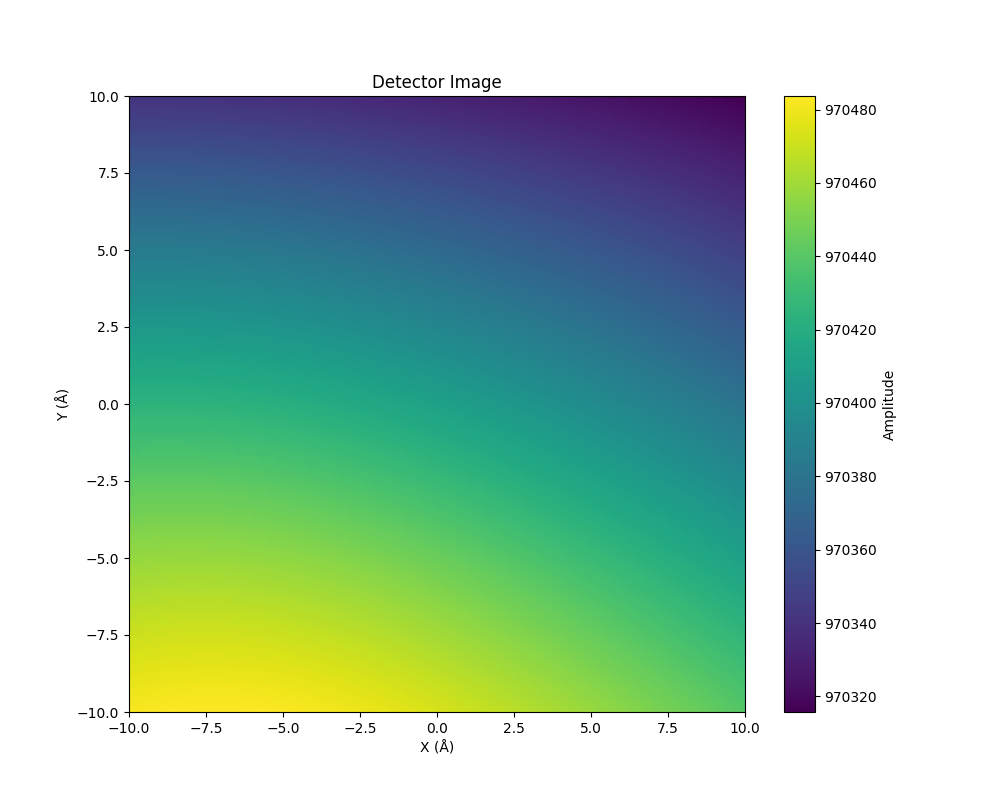

In [63]:

# Plotting the detector pixels
plt.figure(figsize=(10, 8))
plt.imshow(det_image, extent=[-detector_width_x/2, detector_width_x/2, -detector_width_y/2, detector_width_y/2], cmap='viridis')
plt.colorbar(label='Amplitude')
plt.xlabel('X (Å)')
plt.ylabel('Y (Å)')
plt.title('Detector Image')
plt.show()

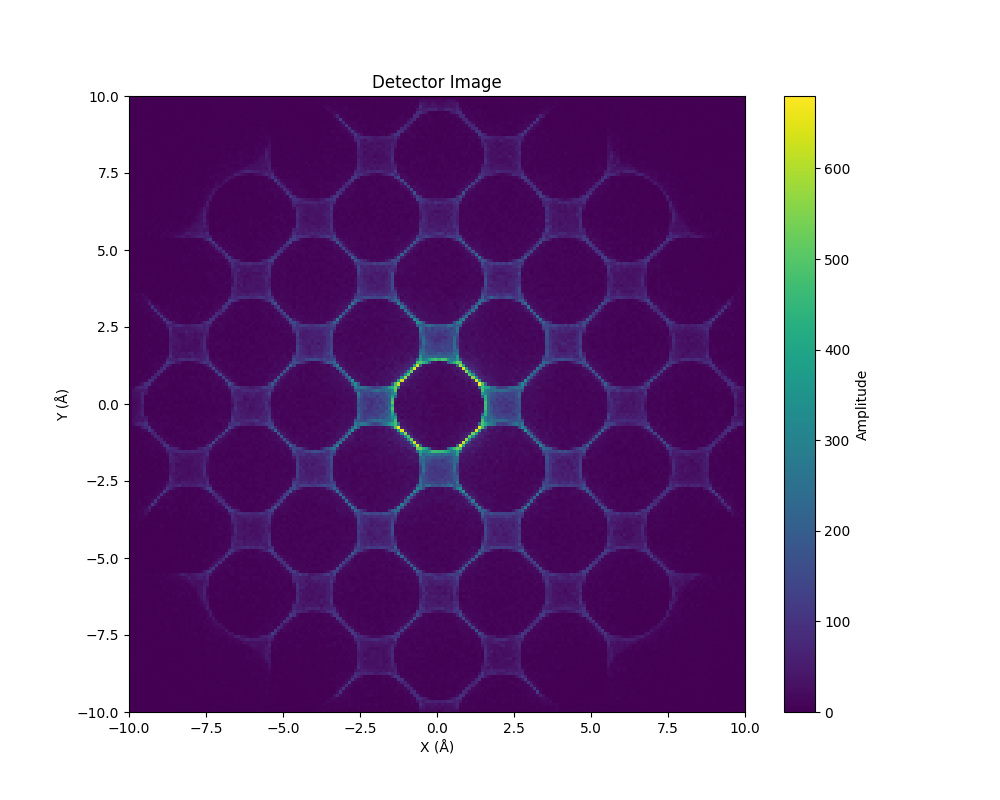

In [64]:
det_image = xp.zeros((n_pixels_x, n_pixels_y), xp.float64)
pixel_coords_x, pixel_coords_y = get_pixel_coords(x, y, det_shape, px_size_x)
pixel_coords_x, pixel_coords_y = xp.round((pixel_coords_x, pixel_coords_y)).astype(int)

sy, sx = det_shape

mask = xp.logical_and(
    xp.logical_and(
        0 <= pixel_coords_y,
        pixel_coords_y < sx
    ),
    xp.logical_and(
        0 <= pixel_coords_x,
        pixel_coords_x < sy
    )
)

# Get indices of ray locations on detector
flat_icds = xp.ravel_multi_index(
    [
        pixel_coords_y[mask],
        pixel_coords_x[mask],
    ],
    det_shape
)

# Add phase at each pixel
xp.add.at(
    det_image.ravel(),
    flat_icds,
    1.0,
)
# If det_image is on GPU, transfer it back to CPU if needed
det_image = xp.asnumpy(det_image)

# Plotting the detector pixels
plt.figure(figsize=(10, 8))
plt.imshow(det_image, extent=[-detector_width_x/2, detector_width_x/2, -detector_width_y/2, detector_width_y/2], cmap='viridis')
plt.colorbar(label='Amplitude')
plt.xlabel('X (Å)')
plt.ylabel('Y (Å)')
plt.title('Detector Image')
plt.show()

In [65]:
# Plotting the detector pixels
# plt.figure(figsize=(10, 8))
# plt.imshow(V[0, :, :], extent = (-half_x, half_x, -half_y, half_y))
# plt.plot(x0s, y0s, '.r', alpha = 0.2)
# plt.colorbar(label='Potential')
# plt.xlabel('X (Å)')
# plt.ylabel('Y (Å)')
# plt.title('Detector Image')
# plt.show()